# Analyse d'une image de microscopie à l'aide du module *scikit-image*  

- Auteurs : William Amory, Jeyani George Clement et Tristan Woh   
- Université de Paris  

Ce notebook a pour objectif d'illustrer une utilisation simplifiée du module *scikit-image* pour l'analyse d'une image de cellules issue d'un microscope photonique à épifluorescence. On cherche à compter le nombre de noyaux présents sur l’image, et à mesurer leur taille et leur intensité de fluorescence.

---
---

## Chargement des modules

In [1]:
# Function for downloading the image to be analyzed.
from urllib.request import urlretrieve

# Basic modules.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Scikit-image sub-modules for image manipulation and analysis.

# Reading and writing an image.
import skimage.io
# Sub-module used to build histograms.
import skimage.exposure
# Sub-module used to perform measurements on the image.
import skimage.measure
# Sub-module for image filtering.
import skimage.filters

# Modules to create interactive graphics.
import plotly
import plotly.express as px
import plotly.graph_objects as go

# Visualization of graphics and images in the notebook.
%matplotlib inline

### Téléchargement et décompression de l'image à analyser

In [2]:
# Download the image if it's not present in the current directory.
if not os.path.isfile("../img/FluorescentCells.zip"):
    print("Downloading the TIFF file for fluorescent cells image...")
    try:
        urlretrieve("https://imagej.nih.gov/ij/images/FluorescentCells.zip",
            "../img/FluorescentCells.zip")
        print("Ok")
    except:
        print("Unable to download the file !")
    print("Done !")

# Unzip the FluorescentCells.zip file if the image is not unzipped.
if not os.path.isfile("../img/FluorescentCells.tif"):
    print("Unzip of FluorescentCells.zip")
    try:
        !unzip ../img/FluorescentCells.zip -d ../img
        print("Ok")
    except:
        print("Unable to unzip the image !")
    print("Done !")

Ok
Done !
Unzip of FluorescentCells.zip
Archive:  ../img/FluorescentCells.zip
  inflating: ../img/FluorescentCells.tif  
Ok
Done !


---

## Chargement et visualisation de l'image à analyser

L'image à analyser provient du [NIH](https://imagej.nih.gov/ij/images/FluorescentCells.zip).
L'image est chargée et stockée dans un tableau *numpy* à l'aide de la fonction `imread()` du sous-module `io` de *scikit-image*.

In [3]:
img = skimage.io.imread("../img/FluorescentCells.tif")

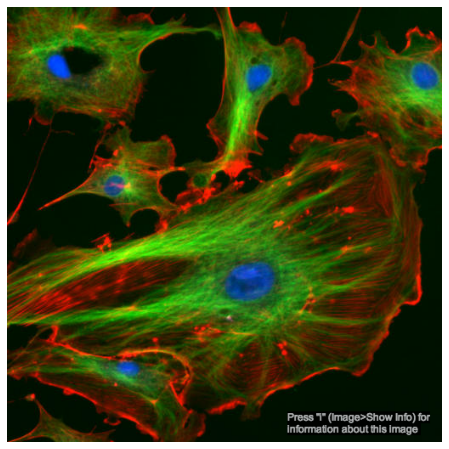

In [4]:
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis("off");

D'après la [description](https://imagej.nih.gov/ij/images/FluorescentCells.txt) de cette image, il s'agit de cellules endothéliales d'artère pulmonaire bovine obtenue par microscopie à épifluorescence. Les filaments d'actine sont marqués en rouge, les microtubules en vert, et les noyaux en bleu.

In [5]:
print(f"Dimensions de l'image : {img.shape}")
print(f"Représentation du pixel (0, 0): {img[0, 0, :]}")

Dimensions de l'image : (512, 512, 3)
Représentation du pixel (0, 0): [16 50  0]


L'image est tridimensionnelle. Les deux premières dimensions correspondent aux coordonnées (ligne, colonne) des pixels de l'image. La dernière dimension correspondant aux différents canaux. C'est une image RGB ; le pixel (0, 0) a pour valeur 16 dans le canal rouge, 50 dans le canal vert, et 0 dans le canal bleu.  

## Sélection du canal d'intérêt
Le canal d'intérêt est le canal bleu, puisque que les noyaux sont marqués au DAPI. Il faut dont utiliser l'indice `2` dans la troisième dimension de ce tableau *numpy* pour le sélectionner (`1` est le canal rouge et `3` le canal vert).

In [6]:
channel_blue = img[:, :, 2]

### Affichage du canal d'intérêt

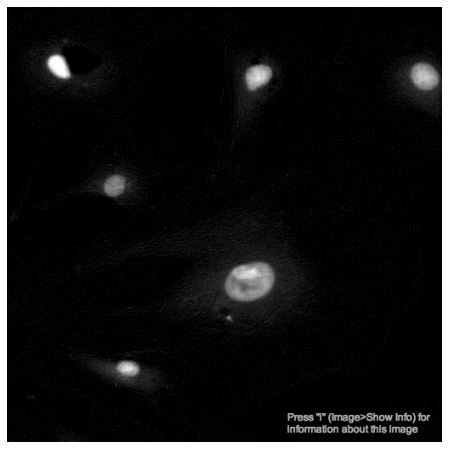

In [7]:
plt.figure(figsize=(8, 8))
plt.imshow(channel_blue, cmap="gray")
plt.axis("off");

La sélection effectuée permet d'identifier les noyaux.

---

## Segmentation des noyaux

Pour sélectionner les noyaux et éliminer le bruit présent sur cette image, nous allons ici utiliser un seuil d'intensité. 

### Estimation du seuil

Pour déterminer ce seuil, nous réalisons un histogramme en utilsant la fonction `histogram` du sous-module `exposure` de *scikit-image*. Cette fonction renvoie les valeurs nécessaires à la construction de l'histogramme représentant la distribution de la valeurs des pixels de l'image.

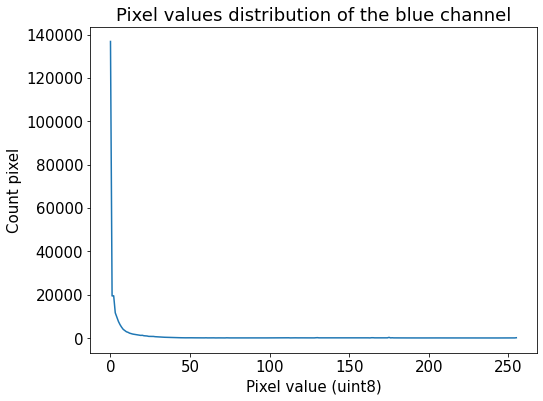

In [8]:
count, pixel_value = skimage.exposure.histogram(channel_blue)
plt.figure(figsize=(8, 6))
plt.rc("font", size=15)
plt.plot(pixel_value, count)
plt.title("Pixel values distribution of the blue channel")
plt.xlabel(f"Pixel value ({channel_blue.dtype})")
plt.ylabel("Count pixel");

La plupart des valeurs de pixel étant nulles (aucune intensité dans le canal bleu), nous fixons une valeur limite sur l'axe des abscisses (ici, 100) pour distinguer les comptes de pixel sur l'ensemble de l'histogramme.

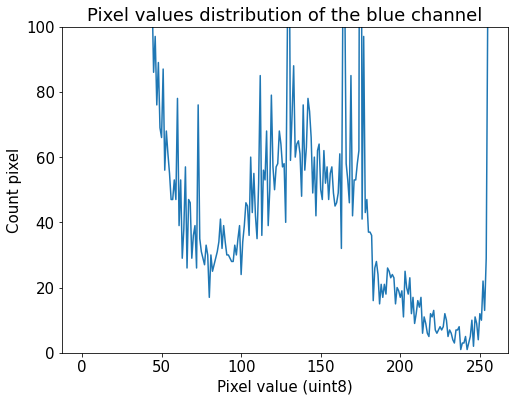

In [9]:
plt.figure(figsize=(8, 6))
plt.rc("font", size=15)
plt.plot(pixel_value, count)
plt.ylim(0, 100)
plt.title("Pixel values distribution of the blue channel")
plt.xlabel(f"Pixel value ({channel_blue.dtype})")
plt.ylabel("Count pixel");

On remarque un minimum local proche de 80 pour la valeur des pixels.

### Segmentation

Nous choisissons donc un seuil de 80 pour la sélection des noyaux.

In [10]:
THRESHOLD = 80
nuclei_mask = channel_blue > THRESHOLD

print(f"{nuclei_mask.dtype}: {np.unique(nuclei_mask)}")

bool: [False  True]


Le tableau *numpy* `nuclei_mask` ainsi créé est en fait un masque booléen. Nous pouvons l'afficher afin de voir les objets segmentés.

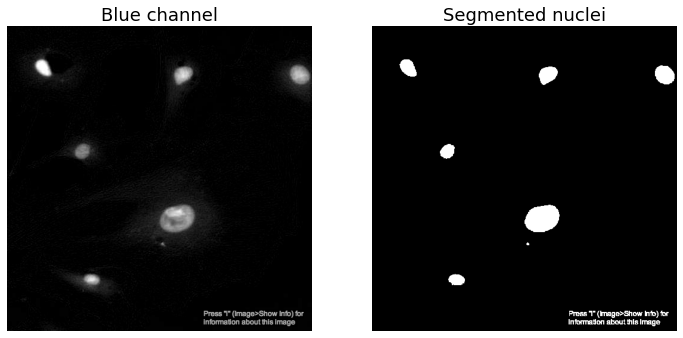

In [11]:
# Create subplots to display all images in a single figure.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 21))

# Make the array of axes 1-dimensional.
axes = axes.ravel()

# Turn off axis lines and labels.
for ax in axes:
    ax.axis("off")

axes[0].imshow(channel_blue, cmap="gray")
axes[0].set_title("Blue channel")

axes[1].imshow(nuclei_mask, cmap="gray")
axes[1].set_title("Segmented nuclei");

Nous constatons que la segmentation a plutôt bien fonctionné : tous les noyaux ont été segmentés. Toutefois, un petit groupe de pixels n'appartenant à aucun noyau se retrouve également segmenté. Pour éviter cet artefact, nous allons réaliser une sélection des noyaux sur la base de l'aire des objets segmentés.  

Afin de pouvoir pousuivre l'analyse de cette image, nous devons retirer la zone de texte qui pourrait biaiser le résultat.

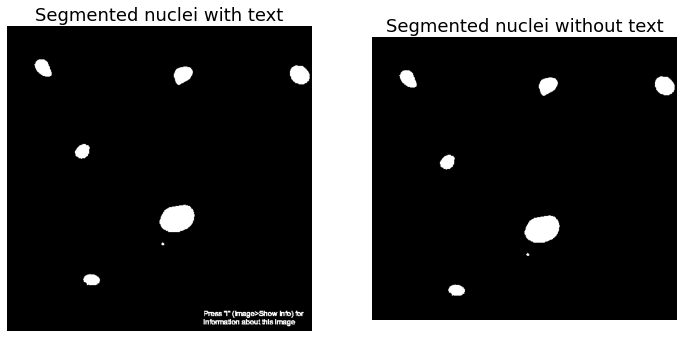

In [12]:
# Create subplots to display all images in a single figure.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 21))

# Make the array of axes 1-dimensional.
axes = axes.ravel()

# Turn off axis lines and labels.
for ax in axes:
    ax.axis("off")

axes[0].imshow(nuclei_mask, cmap="gray")
axes[0].set_title("Segmented nuclei with text")

axes[1].imshow(nuclei_mask[:476, :], cmap="gray")
axes[1].set_title("Segmented nuclei without text");

En sélectionnant les lignes de 0 à 475, cela a retiré la zone de texte sans perte d'information (dans le canal bleu) pour la suite de l'analyse.

In [13]:
nuclei_mask = nuclei_mask[:476, :]
channel_blue = channel_blue[:476, :]

---

## Etiquetage et comptage des noyaux

La fonction `label` du sous-module `measure` de *scikit-image* permet d'étiqueter chaque région contiguë de pixels de même valeur d'un tableau d'entiers. Nous l'utilisons ici pour donner une étiquette à chaque région. En plus, elle retourne aussi le nombre de régions présentes dans le tableau *numpy* avec l'argument `return_num=True`.

In [14]:
# Set nuclei_num to True to return the number of labeled regions as well.
# Background=0 is used to consider 0-valued pixels as background altough
# also a connected region.
nuclei_lab, nuclei_num = skimage.measure.label(nuclei_mask, background=0,
                                               return_num=True)

print(f"Number of segmented objects: {nuclei_num}")

Number of segmented objects: 7


Au total, 7 régions ont été segmentées.

(476, 512)
[0 1 2 3 4 5 6 7]


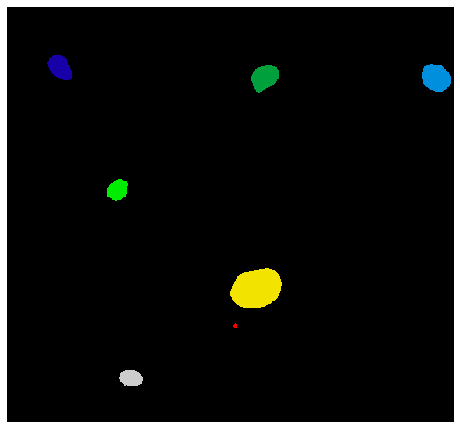

In [15]:
print(nuclei_lab.shape)
print(np.unique(nuclei_lab))
plt.figure(figsize=(8, 8))
plt.imshow(nuclei_lab, cmap="nipy_spectral", interpolation='none')
plt.axis("off");

Le tableau *numpy* étiqueté (`nuclei_lab`) est de même dimension que le tableau d'origine (`true_nuclei`), mais il comporte 8 valeurs distinctes : une valeur pour les pixels du background, et 7 autres valeurs (de 1 à 7) pour les 7 régions segmentées, comme on le constate en affichant l'image étiquetée en couleurs.

Pour retirer l'artefact, nous allons mesurer l'aire des objets et éliminer celui ayant une aire trop petite pour être un noyau.  

### Calcul de l'aire des objets

Nous allons mesurer l'aire des objets segmentés. Pour cela, nous commençons par créer un masque booléen pour chacun des 7 objets segmentés.

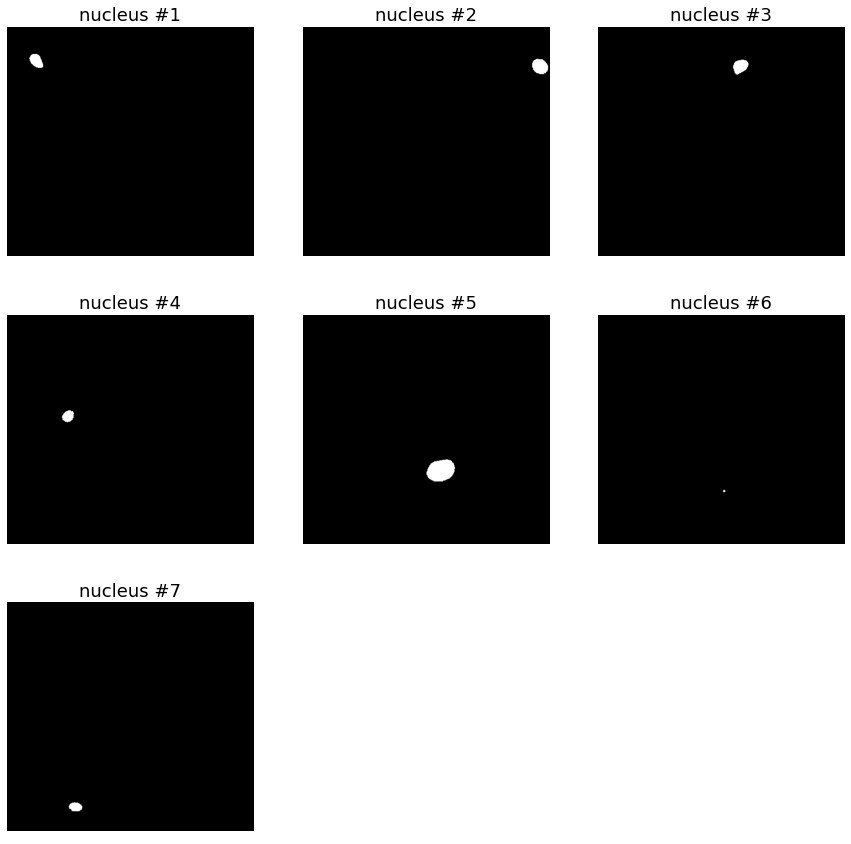

In [16]:
# List to store numpy arrays of each nucleus boolean mask.
nuclei_obj = []

# Create each nucleus boolean mask using its label and append it to nuclei_obj.
for i in range(nuclei_num):
    nuc = (nuclei_lab == i + 1)
    nuclei_obj.append(nuc)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

# Make the array of axes 1-dimensional.
axes = axes.ravel()

# Turn off axis lines and labels.
for ax in axes:
    ax.axis("off")

for i, nuc in enumerate(nuclei_obj):
    axes[i].imshow(nuc, cmap="gray")
    axes[i].set_title("nucleus #" + str(i + 1))

Les tableaux *numpy* ainsi créés sont effectivement les masques booléens de chacun des 7 objets segmentés.  

Pour mesurer l'aire de chaque noyau, nous comptons le nombre de pixels présent dans chaque région. Les pixels étiquetés ayant pour valeur `True` et les autres pixels `False`, il suffit de faire la somme des éléments de chaque masque booléen pour obtenir l'aire (en pixel) de chaque noyau.

In [17]:
# Create empty list to store areas.
nuc_areas = []

# Measure each nucleus area and append it to nuc_areas.
for i in range(nuclei_num):
    area = np.sum(nuclei_obj[i])
    nuc_areas.append(area)
    print(f"nuc_{i + 1} area: {nuc_areas[i]} pixels")

nuc_1 area: 593 pixels
nuc_2 area: 824 pixels
nuc_3 area: 705 pixels
nuc_4 area: 454 pixels
nuc_5 area: 2097 pixels
nuc_6 area: 18 pixels
nuc_7 area: 406 pixels


On remarque que l'objet `nuc_6` a une aire de 18 pixels, une valeur trop faible pour concidérer cet objet comme un noyau. Nous pouvons donc désormais sélectionner les noyaux.  

---

## Sélection des noyaux

Afin de réaliser cette sélection, nous allons créer un tableau *numpy* qui contiendra les objets dont l'aire est supérieure ou égale au seuil fixé de 50 pixels.

Number of nuclei: 6


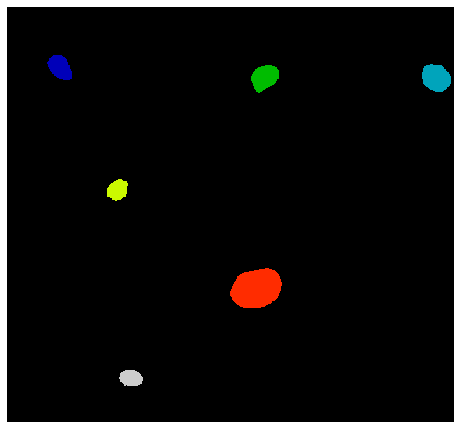

In [18]:
THRESHOLD_AREA = 50
# Make an empty image the same size as our orignal binary image.
approved_nuclei = np.zeros_like(nuclei_mask)

# Loop through each object and test its area.
for i in range(nuclei_num):
    # Get the cell of interest.
    nuclei = (nuclei_lab == i + 1)

    # Compute its area.
    cell_area = np.sum(nuclei)

    # Test if it is within our bounds.
    if (cell_area > THRESHOLD_AREA):

        # Add our extraced cell to our blank image.
        approved_nuclei += nuclei

# Relabel and show the approved_cells mask.
approved_lab, num_obj = skimage.measure.label(approved_nuclei,
                                              return_num=True)

print(f"Number of nuclei: {num_obj}")
plt.figure(figsize=(8, 8))
plt.imshow(approved_lab, cmap="nipy_spectral", interpolation='none')
plt.axis("off");

On remarque que l'artefact n'est plus considéré comme étant un noyau. On compte bien 6 noyaux.  

---

## Méthode alternative : segmentation après filtrage de l'image

Il existe une seconde manière permettant de ne segmenter que des noyaux, en effectuant un filtrage de l'image avant l'étape de segmentation.

Ici, nous appliquerons un filtre gaussien, ce qui permet de réduire le bruit en lissant l'image par une méthode de "convolution". Cette méthode consiste à calculer une nouvelle valeur pour chaque pixel de l'image en faisant la moyenne des valeurs de ce pixel et des pixels l'entourant, le poids relatif donné à chaque pixel étant déterminé par les valeurs contenues dans un kernel (ici, un kernel gaussien).  

L'image filtrée `channel_blue_filtered` est obtenue en appliquant sur le canal bleu (`channel_blue`) la fonction `gaussian()` du sous-module `filters` de *scikit-image*.

In [19]:
channel_blue_filtered = skimage.filters.gaussian(channel_blue,
                                                sigma=2,
                                                preserve_range=True)

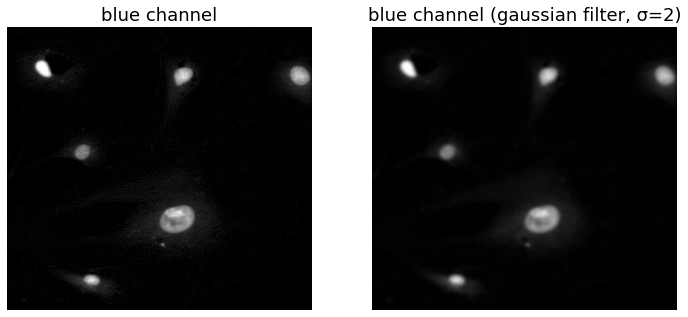

In [20]:
# Create subplots to display all images in a single figure.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 21))

# Make the array of axes 1-dimensional.
axes = axes.ravel()

# Turn off axis lines and labels.
for ax in axes:
    ax.axis("off")

axes[0].imshow(channel_blue, cmap="gray")
axes[0].set_title("blue channel")

axes[1].imshow(channel_blue_filtered, cmap="gray")
axes[1].set_title("blue channel (gaussian filter, σ=2)");

L'artefact étant directement entouré de pixels ayant des valeurs faibles du fait de sa petite aire, on s'attend à ce que le filtrage réduise davantage son intensité que celle des objets identifiés comme des noyaux, qui on une aire plus importante.  

### Segmentation (après filtrage avec le filtre gaussien)

La segmentation est toujours réalisée avec un seuil de 80, mais cette fois sur l'image filtrée avec le filtre gaussien.

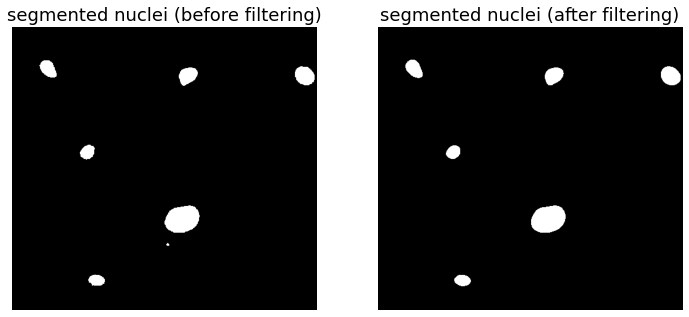

In [21]:
THRESHOLD = 80
true_nuclei = (channel_blue_filtered > THRESHOLD)
true_nuclei = true_nuclei.astype(int)

# Create subplots to display all images in a single figure.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 21))

# Make the array of axes 1-dimensional.
axes = axes.ravel()

# Turn off axis lines and labels.
for ax in axes:
    ax.axis("off")

axes[0].imshow(nuclei_mask, cmap="gray")
axes[0].set_title("segmented nuclei (before filtering)")

axes[1].imshow(true_nuclei, cmap="gray")
axes[1].set_title("segmented nuclei (after filtering)");

L'application du filtre gaussien a permis de ne pas retenir l'artefact lors de la segmentation.

Par contre, comme le filtrage modifie l'image, les régions segmentées ne correspondent pas exactement aux noyaux segmentés précedemment sur l'image non modifiée (ce n'est pas visible ici, mais il y a eu une perte de pixels en périphérie des noyaux). Cela n'est pas souhaitable car nous voulons effectuer diverses mesures sur les noyaux. La première méthode est donc à privilégier.

---

## Mesures sur les noyaux

Nous allons effectuer des mesures sur les noyaux. Pour cela, nous commençons par créer un masque booléen pour chacun des 6 noyaux, comme vu précédemment.

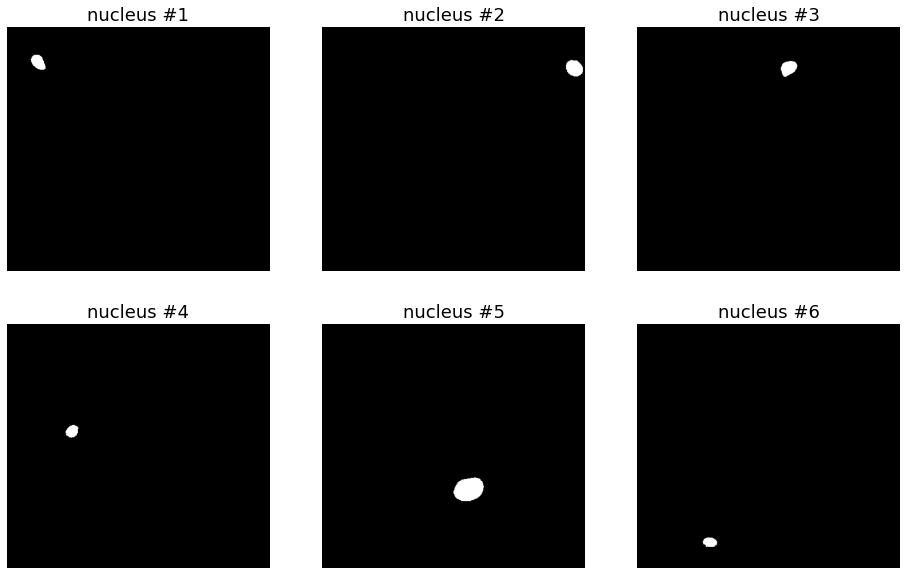

In [22]:
# List to store numpy arrays of each nucleus boolean mask.
nuclei_obj = []

# Create each nucleus boolean mask using its label and append it to nuclei_obj.
for i in range(num_obj):
    nuc = (approved_lab == i + 1)
    nuclei_obj.append(nuc)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))

axes = axes.ravel()

# Turn off axis lines and labels.
for ax in axes:
    ax.axis("off")

for i, nuc in enumerate(nuclei_obj):
    axes[i].imshow(nuc, cmap="gray")
    axes[i].set_title("nucleus #" + str(i + 1))

Les tableaux *numpy* ainsi créés sont effectivement les masques booléens de chacun des 6 noyaux.

### Mesure de l'aire et de l'intensité des noyaux  

Nous avons déjà vu comment mesurer l'aire des noyaux en se servant de ces masques booléens. Voyons maintenant comment mesurer leur intensité.

Pour mesurer l'intensité totale de chaque noyau, nous faisons la somme des valeurs d'intensité contenues dans le tableau *numpy* du canal bleu (`channel_blue`) associées aux pixels appartenant au noyau mesuré. Chaque intensité totale est ensuite divisée par l'aire du noyau correspondant pour obtenir des intensités moyennes.

In [23]:
# Measure nuclei areas.

# Create empty list to  store areas.
nuc_areas = []

# Measure each nucleus area and append it to nuc_areas.
for i in range(num_obj):
    area = np.sum(nuclei_obj[i])
    nuc_areas.append(area)

# Nuclei mean intensities.
# Create empty list to store mean intensities.
nuc_intensities = []

# Measure each nucleus intensity and append it to nuc_intensities.
for i in range(num_obj):
    intensity = np.sum(nuclei_obj[i] * channel_blue) / nuc_areas[i]
    nuc_intensities.append(intensity)


for i in range(num_obj):
    print(f"Nuclei {i + 1}: area = {nuc_areas[i]:>4} pixels ;"
          f" intensity = {nuc_intensities[i]:.2f} per pixel.")

Nuclei 1: area =  593 pixels ; intensity = 202.62 per pixel.
Nuclei 2: area =  824 pixels ; intensity = 144.63 per pixel.
Nuclei 3: area =  705 pixels ; intensity = 156.30 per pixel.
Nuclei 4: area =  454 pixels ; intensity = 113.39 per pixel.
Nuclei 5: area = 2097 pixels ; intensity = 140.00 per pixel.
Nuclei 6: area =  406 pixels ; intensity = 151.20 per pixel.


La taille d'un pixel n'étant pas connue, ces mesures ne peuvent pas être exprimées avec les unités du système métrique.  

Heureusement, ces mesures peuvent également être effectuées à l'aide du module *scikit-image*. La fonction `regionprops` du sous-module `measure` de *scikit-image* décrit un certain nombre de propriétés associées à chaque région étiquetée, dont l'aire, l'intensité moyenne, le périmètre, et l'excentricité. Ces propriétés sont accessibles *via* les attributs associés à l'objet renvoyé par la fonction (par exemple `.perimeter` pour le périmètre).

Toutes les mesures réalisées seront stockés dans un dataframe Pandas (`nuclei_measure`).  

### Mesure de l'aire et de l'intensité des noyaux avec une fonction de *scikit-image*

In [24]:
nuclei_props = skimage.measure.regionprops(approved_lab,
                                           intensity_image=channel_blue)

measure_nuclei = pd.DataFrame(
    {"area": [nuclei_props[i].area for i in range(num_obj)],
     "intensity": [nuclei_props[i].mean_intensity for i in range(num_obj)],
     "perimeter": [nuclei_props[i].perimeter for i in range(num_obj)],
     "eccentricity": [nuclei_props[i].eccentricity for i in range(num_obj)]})

measure_nuclei.to_csv("measure_nuclei.csv", sep=";")

In [25]:
print(measure_nuclei)

   area   intensity   perimeter  eccentricity
0   593  202.618887   93.840620      0.760119
1   824  144.628641  107.254834      0.555364
2   705  156.302128  102.083261      0.665195
3   454  113.394273   80.183766      0.582738
4  2097  139.996662  175.539105      0.686000
5   406  151.201970   79.112698      0.745340


---

## Visualisation des mesures effectuées
La distribution de ces mesures peut être visualisée sous forme d'histogramme.

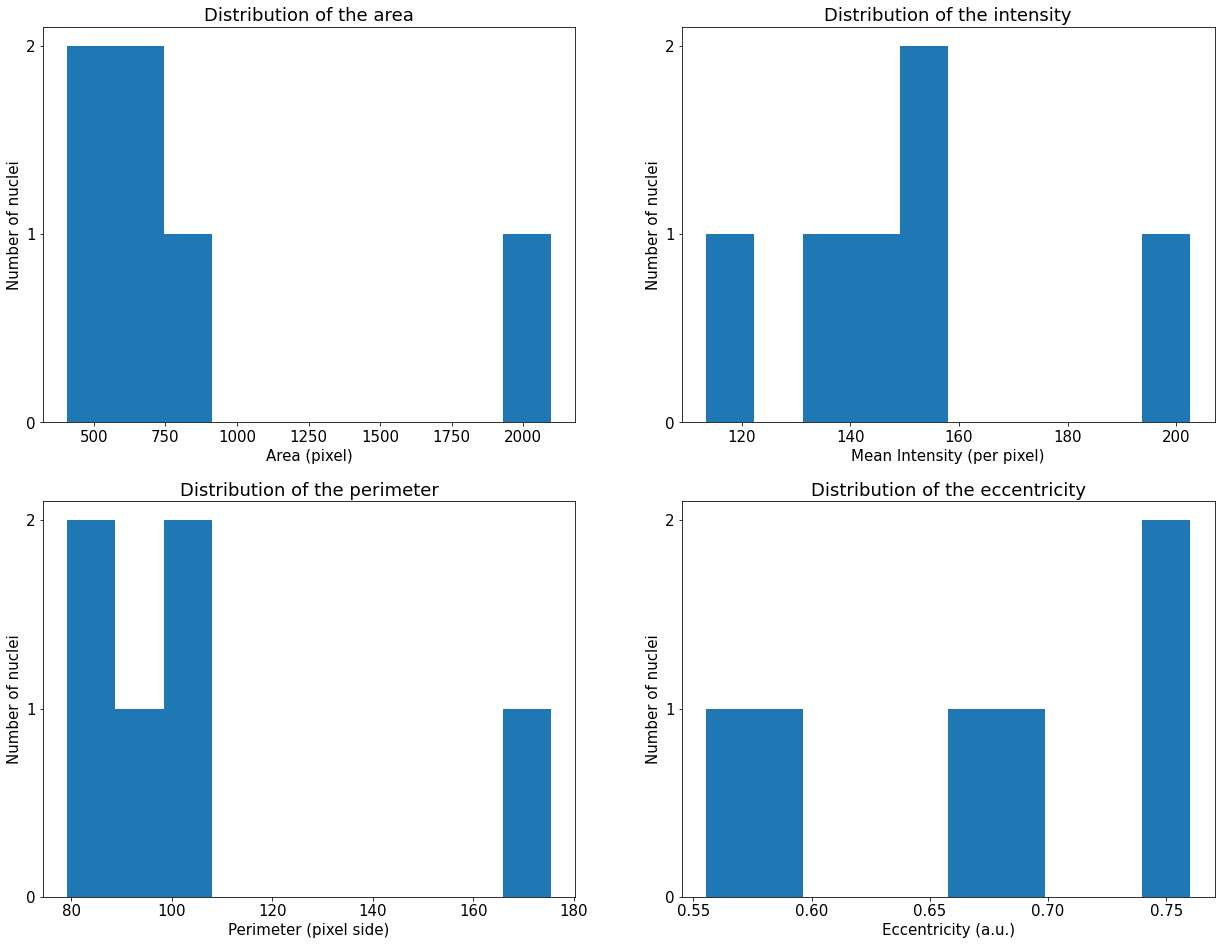

In [26]:
# Create subplots to display all images in a single figure.
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(21, 16))
plt.rc("font", size=15)

# Make the array of axes 1-dimensional.
axes = axes.ravel()

for i, col in enumerate(measure_nuclei.columns):
    axes[i].hist(measure_nuclei[col], bins=10)
    axes[i].set_title(f"Distribution of the {col}")
    axes[i].set_ylabel("Number of nuclei")
    axes[i].set_yticks([0, 1, 2])

axes[0].set_xlabel("Area (pixel)")
axes[1].set_xlabel("Mean Intensity (per pixel)")
axes[2].set_xlabel("Perimeter (pixel side)")
axes[3].set_xlabel("Eccentricity (a.u.)");

### Représentation de l'aire des noyaux en fonction du périmètre
Nous pouvons aussi représenter deux de ces mesures sous forme de nuage de points, ici par exemple l'aire et le périmètre.

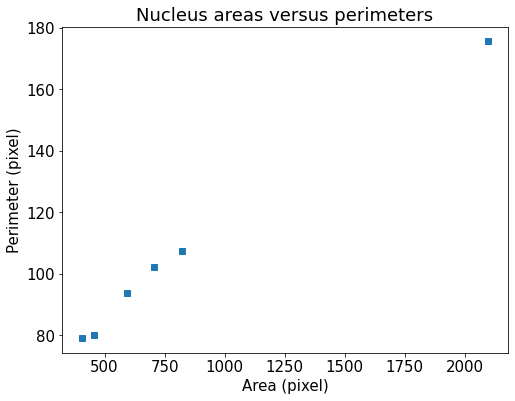

In [27]:
plt.figure(figsize=(8, 6))
plt.rc("font", size=15)
plt.plot(measure_nuclei["area"], measure_nuclei["perimeter"], "s")
plt.title("Nucleus areas versus perimeters")
plt.xlabel("Area (pixel)")
plt.ylabel("Perimeter (pixel)");

---

## Représentation des mesures effectuées sur un graphique intéractif à l'aide du module *Plotly*
Pour finir, nous pouvons utiliser la fonction `.add_trace()` du module `plotly` pour afficher les mesures des noyaux en passant la souris au-dessus de l'image.

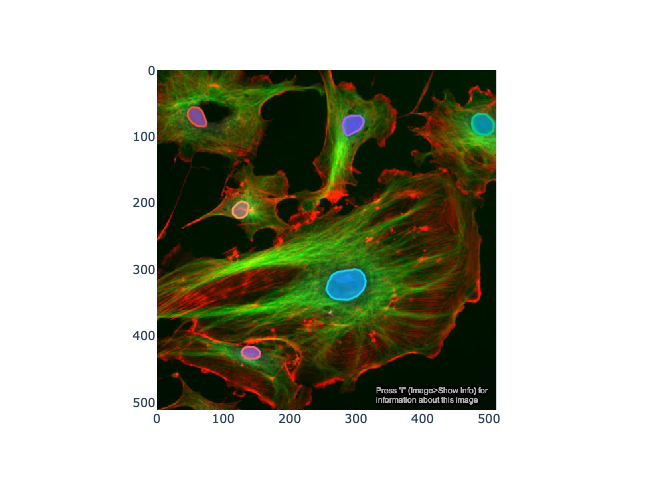

In [28]:
fig = px.imshow(img)
fig.update_layout(autosize=False, width=500, height=500)

# For each label, add a filled scatter trace for its contour,
# and display the properties of the label in the hover of this trace.
for index in range(num_obj):
    label_i = nuclei_props[index].label
    contour = skimage.measure.find_contours(approved_lab == label_i)[0]
    y, x = contour.T
    hoverinfo = ''

    for col in measure_nuclei.columns:
        hoverinfo += f'<b>{col}: {measure_nuclei.loc[index, col]:.2f}</b><br>'

    fig.add_trace(go.Scatter(
        x=x, y=y, name=label_i,
        mode='lines', fill='toself', showlegend=False,
        hovertemplate=hoverinfo, hoveron='points+fills'))

plotly.io.show(fig)